In [1]:
%matplotlib notebook
import timeit
import signal
from contextlib import contextmanager
import pandas as pd
import numpy as np
import sys

from skbio.stats.distance import randdm, DistanceMatrix
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from genomesubsampler.prototypeSelection import *

#### Some helper functions

In [2]:
# translate the function to a more readable name
def tostr(fct):
    if 'function prototype_selection_destructive_maxdist' in str(fct):
        return 'destructive_maxdist'
    elif 'function prototype_selection_constructive_maxdist' in str(fct):
        return 'constructive_maxdist'
    elif 'function prototype_selection_constructive_protoclass' in str(fct):
        return 'constructive_protoclass'
    elif 'function prototype_selection_constructive_pMedian' in str(fct):
        return 'constructive_pMedian'
    return fct

# helper function to wrap function for timeit
def wrapper(func, *args, **kwargs):
    def wrapped():
        global proto_results
        res = []
        try:
            res = func(*args[:2], **kwargs)
        except RuntimeError:
            pass
        proto_results[args[2]][args[4]][args[3]]['prototypes'] = res
    return wrapped

# context to abort a function execution after given number of seconds
class TimeoutException(Exception): pass
@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

## running the actual benchmark
We are iterating over 
 - 6 DistanceMatrix sizes, 
 - 9 numbers of prototypes to select (as a ratio of matrix size) and 
 - over all 4 non-exhaustive algorithms

Execution is aborted after 10 seconds. Timeit uses 1 repeat for every measurement.

In [3]:
timeout = 10  # in seconds. Function will be killed after x seconds time
repeats = 1   # number of repeats for timeit
dm_sizes = [10, 100, 1000, 5000, 10000, 50000]
ratios_prototypes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


# running benchmark
proto_results = dict()
algo_timedout = dict()
for dm_size in dm_sizes:
    print(dm_size, file=sys.stderr)
    # generate random distance matrix of given size
    dm = randdm(dm_size, constructor=DistanceMatrix)
    proto_results[dm_size] = dict()

    for algo in [prototype_selection_destructive_maxdist,
                 prototype_selection_constructive_maxdist,
                 prototype_selection_constructive_protoclass,
                 prototype_selection_constructive_pMedian]:
        print('\t%s ' % tostr(algo), end="", file=sys.stderr)
        proto_results[dm_size][tostr(algo)] = dict()
        for ratio_protos in ratios_prototypes:
            # determine number of prototypes to select as a fraction of dm size
            num_protos = int(dm_size * ratio_protos)

            proto_results[dm_size][tostr(algo)][ratio_protos] = {'runtime': 0, 'distsum': 0, 'prototypes': []}
            if tostr(algo) not in algo_timedout:
                algo_timedout[tostr(algo)] = 0
            if algo_timedout[tostr(algo)] >= len(ratios_prototypes):
                print('skipping', file=sys.stderr)
                break
            if num_protos >= 2:
                wrapped = wrapper(algo, dm, num_protos, dm_size, ratio_protos, tostr(algo))
                try:
                    with time_limit(timeout):
                        proto_results[dm_size][tostr(algo)][ratio_protos]['runtime'] = timeit.timeit(wrapped, number=repeats)/repeats
                        print('.', end="", file=sys.stderr)
                        if len(proto_results[dm_size][tostr(algo)][ratio_protos]['prototypes']) >= 2:
                            proto_results[dm_size][tostr(algo)][ratio_protos]['distsum'] = distance_sum(proto_results[dm_size][tostr(algo)][ratio_protos]['prototypes'], dm)
                        else:
                            proto_results[dm_size][tostr(algo)][ratio_protos]['distsum'] = 0
                except TimeoutException as msg:
                    print('!', end="", file=sys.stderr)
                    proto_results[dm_size][tostr(algo)][ratio_protos]['runtime'] = np.nan
                    proto_results[dm_size][tostr(algo)][ratio_protos]['distsum'] = np.nan
                    algo_timedout[tostr(algo)] += 1
        if algo_timedout[tostr(algo)] < len(ratios_prototypes):
            algo_timedout[tostr(algo)] = 0
        print("", file=sys.stderr)

10
	destructive_maxdist ........
	constructive_maxdist ........
	constructive_protoclass ........
	constructive_pMedian ........
100
	destructive_maxdist .........
	constructive_maxdist .........
	constructive_protoclass .........
	constructive_pMedian .........
1000
	destructive_maxdist .........
	constructive_maxdist .........
	constructive_protoclass .........
	constructive_pMedian !!!!!!!!!
5000
	destructive_maxdist .........
	constructive_maxdist ..!!!!!!!
	constructive_protoclass .........
	constructive_pMedian skipping

10000
	destructive_maxdist .........
	constructive_maxdist !!!!!!!!!
	constructive_protoclass !!!!!!!!!
	constructive_pMedian skipping

50000
	destructive_maxdist ..!.!.!.!.!.!.!.!
	constructive_maxdist skipping

	constructive_protoclass skipping

	constructive_pMedian skipping



## reformatting results into a Pandas DataFrame
and store results into file 'runtime_prototypeSelection.tsv'

In [15]:
res = []
for dm_size in proto_results.keys():
    for algo in proto_results[dm_size].keys():
        for ratio_protos in proto_results[dm_size][algo].keys():
            res.append({
                'dm_size': dm_size,
                'ratio_protos': ratio_protos,
                'runtime': proto_results[dm_size][algo][ratio_protos]['runtime'],
                'distsum': proto_results[dm_size][algo][ratio_protos]['distsum'],
                'algo': algo
            })
res_pd = pd.DataFrame(data=res)
res_pd.to_csv('runtime_prototypeSelection.tsv', sep='\t')

## Plot runtime measurements as 3D wireplot
and save figure as 'runtime_prototypeSelection.pdf'

<IPython.core.display.Javascript object>


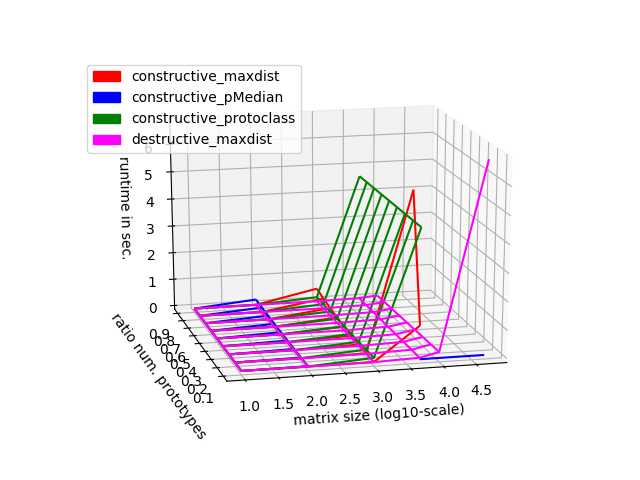

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green', 'magenta']
legend = []
for a, (algo, g) in enumerate(res_pd.groupby('algo')):
    num_dm_sizes = len(g['dm_size'].unique())
    num_ratios = len(g['ratio_protos'].unique())
    X = np.zeros((num_dm_sizes, num_ratios))
    Y = np.zeros((num_dm_sizes, num_ratios))
    Z = np.zeros((num_dm_sizes, num_ratios))
    
    for x, dm_size in enumerate(sorted(g['dm_size'].unique())):
        for y, ratio_protos in enumerate(sorted(g['ratio_protos'].unique())):
            X[x][y] = np.log10(dm_size)
            Y[x][y] = ratio_protos
            times = g[(g['dm_size'] == dm_size) & (g['ratio_protos'] == ratio_protos)]
            if times.shape[0] > 0:
                Z[x][y] = g[(g['dm_size'] == dm_size) & (g['ratio_protos'] == ratio_protos)]['runtime']
            else:
                Z[x][y] = np.nan
          
    ax.plot_wireframe(X, Y, Z, color=colors[a])
    legend.append(mpatches.Patch(color=colors[a], label=algo))

#     break
ax.legend(handles=legend,
          loc='upper left')
ax.set_xlabel('matrix size (log10-scale)')
ax.set_ylabel('ratio num. prototypes')
ax.set_zlabel('runtime in sec.')

plt.show()
plt.savefig('runtime_prototypeSelection.pdf')